In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from scipy import signal
import time
from matplotlib import pyplot as plt
from PIL import Image
import torchaudio
from torchaudio import functional as F

In [3]:
#input must be tensor with float (each bit)
def IndA_diff(input):
    weights = torch.tensor([[-7.8433e-04, 37.006, 37.006, 37.006, 37.005, 37.006, 37.006, 37.007]],dtype=torch.float64)
    bias = torch.tensor([-131.3873],dtype=torch.float64)
    linear_output = torch.matmul(input, weights.t()) + bias
    output = torch.sigmoid(linear_output)

    return output.item()

In [4]:
# Definir el modelo de regresión logística1
class LogisticRegressionB(nn.Module):
    def __init__(self):
        super(LogisticRegressionB, self).__init__()
        self.linear1 = nn.Linear(9, 20,dtype=torch.float64) 
        self.linear2 = nn.Linear(20, 10,dtype=torch.float64)
        self.linear3 = nn.Linear(10, 1,dtype=torch.float64)

    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x

In [5]:
# Definir el modelo de regresión logística
class LogisticRegressionD(nn.Module):
    def __init__(self):
        super(LogisticRegressionD, self).__init__()
        self.linear1 = nn.Linear(9, 10,dtype=torch.float64) # 9 entradas y 20 salida
        self.linear2 = nn.Linear(10, 5,dtype=torch.float64)
        self.linear3 = nn.Linear(5, 1,dtype=torch.float64)

    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x

In [6]:
IndB = LogisticRegressionB()
state_dictB = torch.load('indicatrizB.pth')
IndB.load_state_dict(state_dictB)
#input must be tensor with float (each bit)
def IndB_diff(bits):
    return IndB(bits).item()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 60,dtype=torch.float64)  
        self.fc2 = nn.Linear(60, 30,dtype=torch.float64)
        self.fc3 = nn.Linear(30, 20,dtype=torch.float64)
        self.fc4 = nn.Linear(20, 1,dtype=torch.float64)    
        self.sigmoid = nn.Sigmoid()  # Función de activación sigmoide

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [8]:
IndE = Net()
state_dictE = torch.load('indicatrizE.pth')
IndE.load_state_dict(state_dictE)
#bits must be tensor and cnt integer
def IndE_diff(bits,cnt):
    cnt = torch.tensor([cnt],dtype=torch.float64)
    input = torch.cat((bits,cnt))
    return IndE(input).item()

In [9]:
IndC = Net()
state_dictC = torch.load('indicatrizC.pth')
IndC.load_state_dict(state_dictC)
#bits must be tensor and cnt integer
def IndC_diff(bits,cnt):
    cnt = torch.tensor([cnt],dtype=torch.float64)
    input = torch.cat((bits,cnt))
    return IndC(input).item()

In [10]:
IndD = LogisticRegressionD()
state_dictD = torch.load('indicatrizD.pth')
IndD.load_state_dict(state_dictD)
#input must be tensor with float (each bit)
def IndD_diff(bits):
    return IndD(bits).item()

In [11]:
def NegBit_diff(x):
    return 1 / (1 + np.exp(-(-15.43*x + 7.51)))

In [12]:
def Real2Bit_diff(x):
    return 1 / (1 + np.exp(-(-5.43 + 10.81*x)))

In [13]:
def XNOR_diff(x1, x2):
    fc1_weight = torch.tensor([[4.7662,  4.8464],[-0.1215,  1.3168],[ 2.6322,  2.3068],[-0.0951, -0.4683]],dtype=torch.float64)
    fc1_bias = torch.tensor([-1.5654,  0.3904, -3.6841, -0.0062],dtype=torch.float64)
    fc2_weight = torch.tensor([[-5.6381,  1.5594,  5.0998, -0.2311]],dtype=torch.float64)
    fc2_bias = torch.tensor([1.7433],dtype=torch.float64)

    x = torch.tensor([x1, x2],dtype=torch.float64)
    fc1_output = torch.sigmoid(torch.matmul(x, fc1_weight.transpose(0, 1)) + fc1_bias)
    fc2_output = torch.sigmoid(torch.matmul(fc1_output, fc2_weight.transpose(0, 1)) + fc2_bias)

    return fc2_output.item()

In [14]:
def XOR_diff(x1, x2):
    fc1_weight = torch.tensor([[-3.8973,  4.0330],[-4.1031,  3.8928],[-0.6775,  0.8108],[ 2.3834, -2.4550]],dtype=torch.float64)
    fc1_bias = torch.tensor([ 2.2917, -2.1209, -0.6751, -1.6954],dtype=torch.float64)
    fc2_weight = torch.tensor([[-4.5110,  5.7411,  1.0059,  2.4664]],dtype=torch.float64)
    fc2_bias = torch.tensor([0.8839],dtype=torch.float64)

    x = torch.tensor([x1, x2],dtype=torch.float64)
    fc1_output = torch.sigmoid(torch.matmul(x, fc1_weight.transpose(0, 1)) + fc1_bias)
    fc2_output = torch.sigmoid(torch.matmul(fc1_output, fc2_weight.transpose(0, 1)) + fc2_bias)

    return fc2_output.item()

In [15]:
def OR_diff(x1, x2):
    weight = torch.tensor([[13.5223, 13.5223]],dtype=torch.float64)
    bias = torch.tensor([-6.3024],dtype=torch.float64)
    x = torch.tensor([x1, x2],dtype=torch.float64)
    output = torch.sigmoid(torch.matmul(x, weight.transpose(0, 1)) + bias)

    return output.item()

In [42]:
#input must be float (each bit)
def q_m_diff(input):
    t_input = torch.tensor(input.copy(),dtype=torch.float64)
    output = torch.tensor([t_input[0], 0, 0, 0, 0, 0, 0, 0, 0],dtype=torch.float64)
    for bit in range(1, 8):
        output[bit] = IndA_diff(t_input) * Real2Bit_diff(XNOR_diff(output[bit-1], t_input[bit])) + (1 - IndA_diff(t_input)) * Real2Bit_diff(XOR_diff(output[bit-1],t_input[bit]))
    output[8] = 1 - IndA_diff(t_input)
    return output


In [43]:
#input must be float (each bit) example: [0.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0], 2.0
#output are tensors
def TMDS_diff(pixel_bits,cnt):
    bits_inversos = pixel_bits[::-1]
    q_m = q_m_diff(bits_inversos)
    q_m = Real2Bit_diff(q_m)
    output = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],dtype=torch.float64)
    output[8:] = q_m[8:] * OR_diff(IndE_diff(q_m[:8],cnt) * IndB_diff(q_m[:9]),(1-IndC_diff(q_m[:8],cnt)) * (1-IndE_diff(q_m[:8],cnt))) + NegBit_diff(q_m[8:]) * OR_diff((1 - IndB_diff(q_m[:9])) * IndE_diff(q_m[:8],cnt),IndC_diff(q_m[:8],cnt) * (1 - IndE_diff(q_m[:8],cnt)))
    output[8] = q_m[8]
    output[9] = IndE_diff(q_m[:8],cnt) * NegBit_diff(q_m[8]) + (1 - IndE_diff(q_m[:8],cnt)) * IndC_diff(q_m[:8],cnt)
    new_cnt = IndE_diff(q_m[:8],cnt) * ((cnt + torch.sum(q_m[:8] < 0.5).item() - torch.sum(q_m[:8] > 0.5).item()) * IndD_diff(q_m) + (cnt + torch.sum(q_m[:8] > 0.5).item() - torch.sum(q_m[:8] < 0.5).item()) * (1 - IndD_diff(q_m))) + (1 - IndE_diff(q_m[:8],cnt)) * ((cnt + 2 * q_m[8] + torch.sum(q_m[:8] < 0.5).item() - torch.sum(q_m[:8] > 0.5).item()) * IndC_diff(q_m[:8],cnt) + (cnt - 2 * NegBit_diff(q_m[8]) + torch.sum(q_m[:8] > 0.5).item() - torch.sum(q_m[:8] < 0.5).item()) * (1 - IndC_diff(q_m[:8],cnt)))
    return output,new_cnt

In [18]:
def sigmoid(x):
    if x >= 0:
        return 1 / (1 + np.exp(-x))
    else:
        return np.exp(x) / (1 + np.exp(x))

def Pixel2Bit_diff(pixel):
    output = [0, 0, 0, 0, 0, 0, 0, 0]
    for i in range(1,9):
        output[i-1] = sigmoid(10*(pixel-2**(8-i)+0.5))  # 0.5 para ajustar la sigmoidal
        if pixel >= 2**(8-i):
            pixel = pixel - 2**(8-i)
    return output


In [19]:
#funcion que toma como entrada el armonico a sintonizar y las dimensiones de la imagen a espiar y devuelve un array con taps de g(t)
def g_taps(dim_vertical, dim_horizontal, armonico):

    #defino variables iniciales
    f_b = 10 * (dim_vertical * dim_horizontal * 60)
    f_sdr = 50e6
    harm = armonico * f_b
    
    #para el correcto funcionamiento: dependiendo del armonico, elijo cuantas muestras por pulso
    if (armonico < 5 ):
        muestras_por_pulso  = 10
    else:
        muestras_por_pulso  = 20

    samp_rate = muestras_por_pulso * f_b
    H_samples = dim_horizontal * muestras_por_pulso

    #creo el pulso
    t_continuous = np.linspace(start = 0, stop = H_samples/samp_rate, num = H_samples, endpoint= False)
    pulso = np.zeros(H_samples)
    pulso[:muestras_por_pulso] = 0.7/255

    #traslado el espectro del pulso el armonico correspondiente
    frec_armonico = np.exp(-2j*np.pi*harm*t_continuous)
    pulso_complejo = pulso*frec_armonico

    #creo el lpf del sdr
    b, a = signal.butter(6, f_sdr/2, fs=samp_rate, btype='lowpass', analog=False)

    #filtro con lpf el pulso multiplicado por armonico. El resultado es g
    g_t = signal.lfilter(b, a, pulso_complejo)

    # si arminico crece, necesito mas taps
    if (armonico < 5):
        g_t = g_t[:1500]
    else:
        g_t = g_t[:3000]

    g_t_max = np.max(np.abs(g_t))
    g_t = g_t / g_t_max

    return torch.tensor(g_t,dtype = torch.complex64)

In [40]:
def forward(img, armonico):
    filas, columnas = img.shape
    bits_codificados = torch.zeros(10*columnas*filas,dtype = torch.complex64)
    g_t = g_taps(filas, columnas, armonico)
    for i in range(filas):
        cnt = 0
        for j in range(columnas):
            pixel = img[i,j]
            pixel_bits = Pixel2Bit_diff(pixel)
            bits_cods, cnt = TMDS_diff(pixel_bits, cnt)
            bits_codificados[i*columnas + j*10:i*columnas + (j+1)*10] = bits_cods
    return bits_codificados,g_t

In [41]:
imag = np.zeros((256,256))
armonico = 3 
bits,g_t = forward(imag, armonico)

In [36]:
filas = 256
columnas= 256
conv = F.convolve(bits,g_t,mode="same")
print(conv.shape)
img=torch.zeros((256,256),dtype = torch.complex64)
for i in range(filas):
    for j in range(columnas):
        img[i,j] = conv[filas*i + 10*j]

torch.Size([655360])


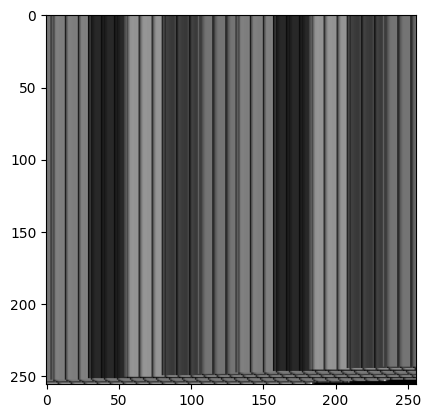

In [37]:
img_sim = img
plt.figure()
#plt.imshow(np.abs((img_sim - img_sim.min())/(img_sim.max()-img_sim.min())),cmap='gray')
plt.imshow(np.abs(img_sim),cmap='gray')
plt.show()

In [24]:
I_save = 255*np.abs(img_sim.numpy())
im = Image.fromarray(I_save.astype('uint8'))
im.save('../images/test.png')